# U-Net Nodules Segmentation Script

I think that one of the most important steps in this problem is the features construction for scans. The features of scans of the same patient can be aggregated and in the result the standard classification problem can be received.  Scan features can be constructed using nodules segmentation approach, which can be performed by convolutional neural network autoencoder. For this task, the CNN U-net can be used. On the training scans, the suspicious nodules can be selected and appropriate  masks for these nodules can be created. Using the autoencoder, one can find the places on the scans for selected types of nodules or suspicious elements one scans. Having  coordinates and types of nodules, we can create the features for the classification problem. For example, a feature can be the amount of different types of nodules in different places of lungs. For the demonstration of the main idea, we chose arbitrary scans and selected arbitrary elements on the scans. 

Bohdan Pavlyshenko <br>
Email:b.pavlyshenko@gmail.com <br>
LinkedIn:http://www.linkedin.com/in/bpavlyshenko <br>

##### References: 
http://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/ <br>
https://github.com/jocicmarko/ultrasound-nerve-segmentation <br>
http://zongwei.leanote.com/post/b89e3ec64214
 

In [19]:
%matplotlib inline
import numpy as np
import dicom
import glob
from matplotlib import pyplot as plt
import os
import cv2
import pandas as pd
from keras.models import Sequential,load_model,Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Input, merge, UpSampling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K


In [2]:
def load_scans(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key=lambda x: int(x.InstanceNumber))
    return np.stack([s.pixel_array for s in slices])

def get_scans(df,scans_list):
    scans=np.stack([load_scans(scan_folder+df.id[i_scan[0]])[i_scan[1]] for i_scan in scans_list])
    scans=process_scans(scans)
    view_scans(scans)
    return(scans)

def process_scans(scans):
    scans1=np.zeros((scans.shape[0],1,img_rows,img_cols))
    for i in range(scans.shape[0]):
        img=scans[i,:,:]
        img = 255.0 / np.amax(img) * img
        img =img.astype(np.uint8)
        img =cv2.resize(img, (img_rows, img_cols))
        scans1[i,0,:,:]=img
    return (scans1)

def view_scans(scans):
    %matplotlib inline
    for i in range(scans.shape[0]):
        print ('scan '+str(i))
        plt.imshow(scans[i,0,:,:], cmap=plt.cm.gray)
        plt.show()

def view_scans_widget(scans):
    %matplotlib tk
    for i in range(scans.shape[0]):
        plt.figure(figsize=(7,7))
        plt.imshow(scans[i,0,:,:], cmap=plt.cm.gray)
        plt.show()

def get_masks(scans,masks_list):
    %matplotlib inline
    scans1=scans.copy()
    maxv=255
    masks=np.zeros(shape=(scans.shape[0],1,img_rows,img_cols))
    for i_m in range(len(masks_list)):
        for i in range(-masks_list[i_m][3],masks_list[i_m][3]+1):
            for j in range(-masks_list[i_m][3],masks_list[i_m][3]+1):
                masks[masks_list[i_m][0],0,masks_list[i_m][2]+i,masks_list[i_m][1]+j]=1
        for i1 in range(-masks_list[i_m][3],masks_list[i_m][3]+1):
            scans1[masks_list[i_m][0],0,masks_list[i_m][2]+i1,masks_list[i_m][1]+masks_list[i_m][3]]=maxv=255
            scans1[masks_list[i_m][0],0,masks_list[i_m][2]+i1,masks_list[i_m][1]-masks_list[i_m][3]]=maxv=255
            scans1[masks_list[i_m][0],0,masks_list[i_m][2]+masks_list[i_m][3],masks_list[i_m][1]+i1]=maxv=255
            scans1[masks_list[i_m][0],0,masks_list[i_m][2]-masks_list[i_m][3],masks_list[i_m][1]+i1]=maxv=255
    for i in range(scans.shape[0]):
        print ('scan '+str(i))
        f, ax = plt.subplots(1, 2,figsize=(10,5))
        ax[0].imshow(scans1[i,0,:,:],cmap=plt.cm.gray)
        ax[1].imshow(masks[i,0,:,:],cmap=plt.cm.gray)
        plt.show()
    return(masks)

def augmentation(scans,masks,n):
    datagen = ImageDataGenerator(
        featurewise_center=False,   
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=25,   
        width_shift_range=0.3,  
        height_shift_range=0.3,   
        horizontal_flip=True,   
        vertical_flip=True,  
        zoom_range=False)
    i=0
    scans_g=scans.copy()
    for batch in datagen.flow(scans, batch_size=1, seed=1000): 
        scans_g=np.vstack([scans_g,batch])
        i += 1
        if i > n:
            break
    i=0
    masks_g=masks.copy()
    for batch in datagen.flow(masks, batch_size=1, seed=1000): 
        masks_g=np.vstack([masks_g,batch])
        i += 1
        if i > n:
            break
    return((scans_g,masks_g))


K.set_image_dim_ordering('th')   

smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def unet_model():
    inputs = Input((1, img_rows, img_cols))
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool1)
    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(pool2)
    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(pool3)
    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(pool4)
    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(conv5)

    up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=1)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(up6)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv6)

    up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=1)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(up7)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv7)

    up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=1)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up8)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv8)

    up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=1)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(up9)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv9)

    conv10 = Convolution2D(1, 1, 1, activation='sigmoid')(conv9)

    model = Model(input=inputs, output=conv10)

    model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])

    return model

def predict_segments(model,scans):
    pred = model.predict(scans, verbose=1)
    for i in range(scans.shape[0]):
        print ('scan '+str(i))
        f, ax = plt.subplots(1, 2,figsize=(10,5))
        ax[0].imshow(scans[i,0,:,:],cmap=plt.cm.gray)
        ax[1].imshow(pred[i,0,:,:],cmap=plt.cm.gray)
        plt.show()

In [3]:
img_rows = 256
img_cols = 256
scan_folder='data/stage1/'
df=pd.read_csv('data/stage1_labels.csv')

In [4]:
# Set up scans list for training  in the format [[id,number_of_scan],...]
scans_list=[[125,100],[245,100],[150,100]]

scan 0


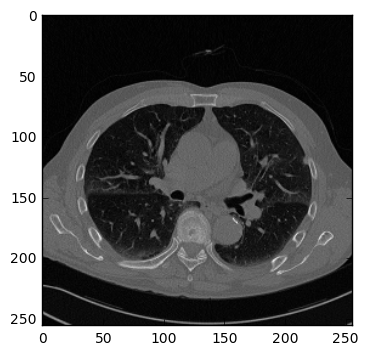

scan 1


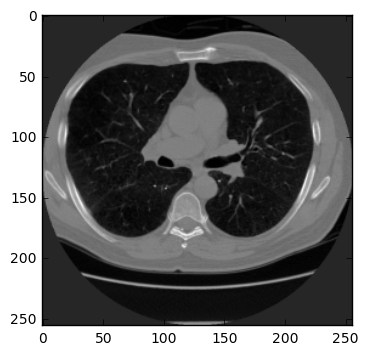

scan 2


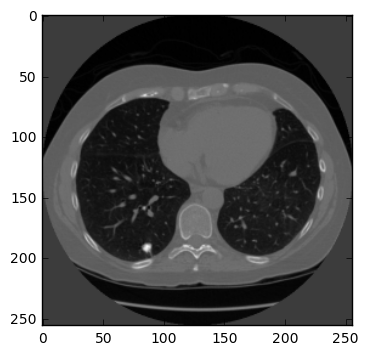

In [5]:
scans=get_scans(df,scans_list)

In [21]:
# View scans in the matplotlib widgets to get coordinates 
view_scans_widget(scans)

In [22]:
# Set up masks list in the format [[scan_number,x_coordinate,y_coordinate, size],]
masks_list=[ [0,92,180,7],[0,174,104,7],[0,181,178,7],
           [1,180,85,7],[1,164,152,7],[2,87,191,7]]

scan 0


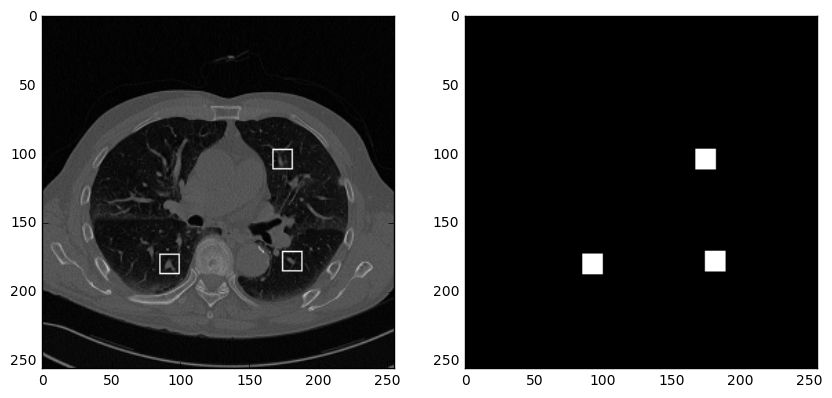

scan 1


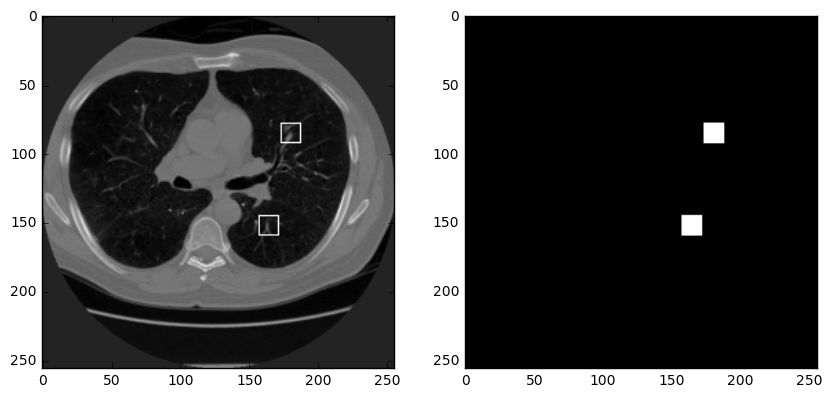

scan 2


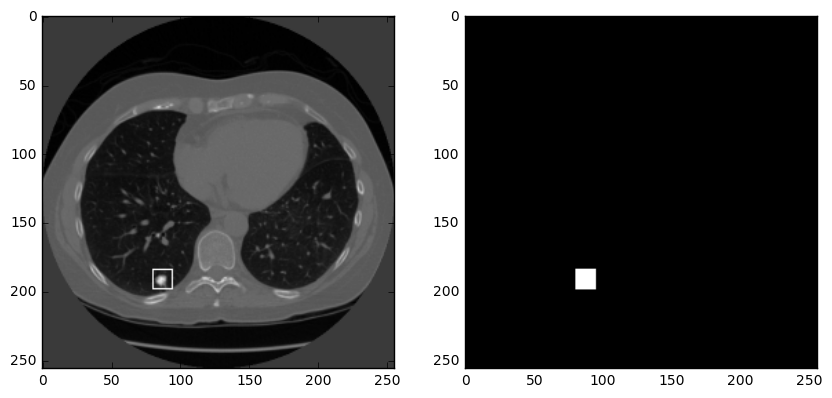

In [23]:
masks=get_masks(scans,masks_list)

In [25]:
model = unet_model()
# Simultaneous augmentation of scans and masks
scans_g, masks_g=augmentation(scans,masks,350)
# model training
model.fit(scans_g, masks_g, batch_size=16, nb_epoch=15, verbose=1, shuffle=True)

Epoch 1/15
354/354 [==============================] - 38s - loss: -0.0188 - dice_coef: 0.0188    
Epoch 2/15
354/354 [==============================] - 38s - loss: -0.0289 - dice_coef: 0.0289    
Epoch 3/15
354/354 [==============================] - 37s - loss: -0.0634 - dice_coef: 0.0634    
Epoch 4/15
354/354 [==============================] - 37s - loss: -0.1197 - dice_coef: 0.1197    
Epoch 5/15
354/354 [==============================] - 37s - loss: -0.1966 - dice_coef: 0.1966    
Epoch 6/15
354/354 [==============================] - 37s - loss: -0.2054 - dice_coef: 0.2054    
Epoch 7/15
354/354 [==============================] - 37s - loss: -0.3159 - dice_coef: 0.3159    
Epoch 8/15
354/354 [==============================] - 37s - loss: -0.2379 - dice_coef: 0.2379    
Epoch 9/15
354/354 [==============================] - 37s - loss: -0.3277 - dice_coef: 0.3277    
Epoch 10/15
354/354 [==============================] - 37s - loss: -0.4182 - dice_coef: 0.4182    
Epoch 11/15
354/354

354/354 [==============================] - 12s    
scan 0


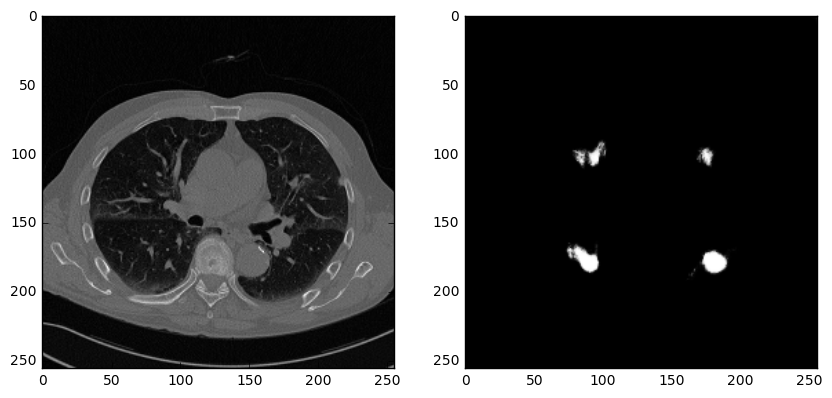

scan 1


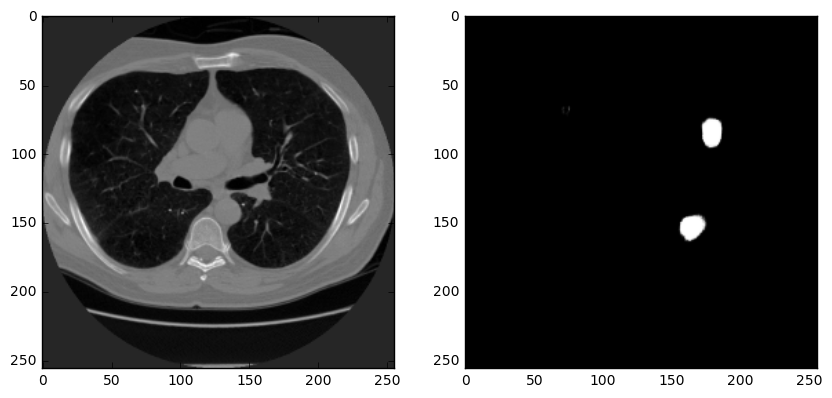

scan 2


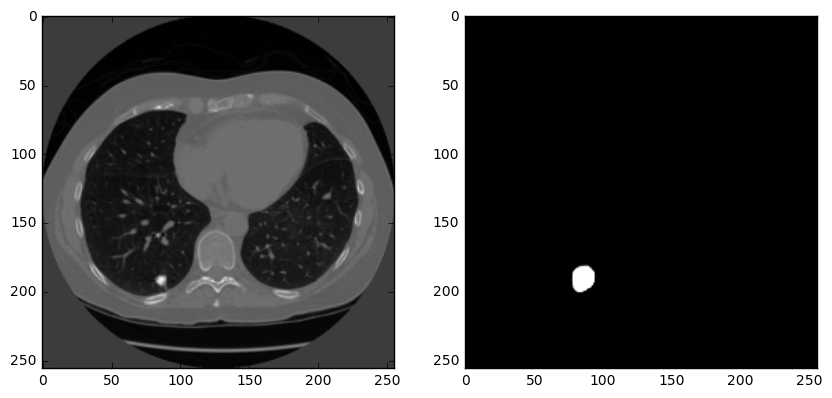

In [26]:
# Perform segmentation on the scans set 
predict_segments(model,scans)